25/01/16 03:31:57 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Building prefix dict from the default dictionary ...                (0 + 4) / 4]
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 4.458 seconds.
Prefix dict has been built successfully.
Loading model cost 4.040 seconds.
Prefix dict has been built successfully.
Loading model cost 3.823 seconds.
Prefix dict has been built successfully.
Loading model cost 4.031 seconds.
Prefix dict has been built successfully.


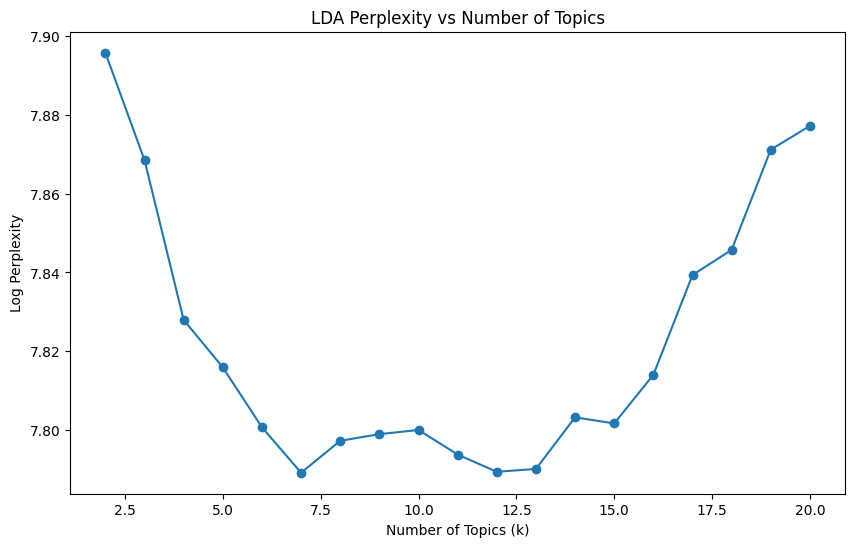

最佳主題數量: 7


主題 0:
  病毒: 0.02323844150190459
  美國: 0.010599800432757782
  疫情: 0.009940253014073476
  新冠: 0.008068229667689194
  防疫: 0.007902475885205576
  感染: 0.005446555412677593
  口罩: 0.005326011329494431
  中國: 0.004578306082746688
  肺炎: 0.003996583869964888
  政策: 0.003796740977892309
主題 1:
  疫苗: 0.029910480403510784
  接種: 0.007612487669844637
  感染: 0.007167570383679077
  新冠: 0.005914767734900064
  治療: 0.005183498036519203
  疾病: 0.004971692780347767
  病毒: 0.004834188966448653
  醫師: 0.004167425816755054
  免疫: 0.003915185588747194
  風險: 0.0037753677031919244
主題 2:
  口罩: 0.02297147308027605
  酒精: 0.009547454852005127
  爆炸: 0.00550214317266425
  女性: 0.005060119696954585
  呼吸: 0.0046505043721967185
  香港: 0.00464815865187548
  健康: 0.0043006031835952155
  敬老: 0.004083768709203406
  二氧化碳: 0.0036711544253383516
  性別: 0.0035551550435998554
主題 3:
  香蕉: 0.00871674579396367
  詐騙: 0.006417312485915967
  騙: 0.0048724025805147635
  簡訊: 0.004228302014996031
  芒果: 0.0036214283622062506
  連結: 0.0035785382896849328


/tmp/ipykernel_3316/1742064465.py:127: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_texts = doc_topics_pd.groupby("dominant_topic").apply(


每個主題的 Top Texts:
主題 0:
  文本: 政治與政策, 分數: 0.9991256776130107
  文本: 健康, 分數: 0.9991029097038897
  文本: 健康, 分數: 0.9987451073650992
  文本: 政治與政策, 分數: 0.9982637007234633
  文本: 健康, 分數: 0.9982020883135494
主題 1:
  文本: 健康, 分數: 0.9996271154683946
  文本: 健康, 分數: 0.9994735437821285
  文本: 國際, 分數: 0.9993858645921336
  文本: 健康, 分數: 0.9993486579562294
  文本: 健康, 分數: 0.9993462380105002
主題 2:
  文本: 健康, 分數: 0.9993489220330164
  文本: 政治與政策, 分數: 0.9976136615442424
  文本: 國際, 分數: 0.9975921109341725
  文本: 生活, 分數: 0.9972576801698861
  文本: 生活, 分數: 0.9919627090081805
主題 3:
  文本: 環境能源, 分數: 0.9987689192710583
  文本: 生活, 分數: 0.9980637594420243
  文本: 科技資安, 分數: 0.9979409738128725
  文本: 生活, 分數: 0.9979312158704238
  文本: 科技資安, 分數: 0.9977600292576214
主題 4:
  文本: 政治與政策, 分數: 0.9993163370289339
  文本: 政治與政策, 分數: 0.9991866602523297
  文本: 政治與政策, 分數: 0.9990592348748859
  文本: 政治與政策, 分數: 0.9989563367685423
  文本: 政治與政策, 分數: 0.9988317803836637
主題 5:
  文本: 政治與政策, 分數: 0.9990298468075457
  文本: 政治與政策, 分數: 0.9987453556690781
  文本: 國際, 分數: 0.9986

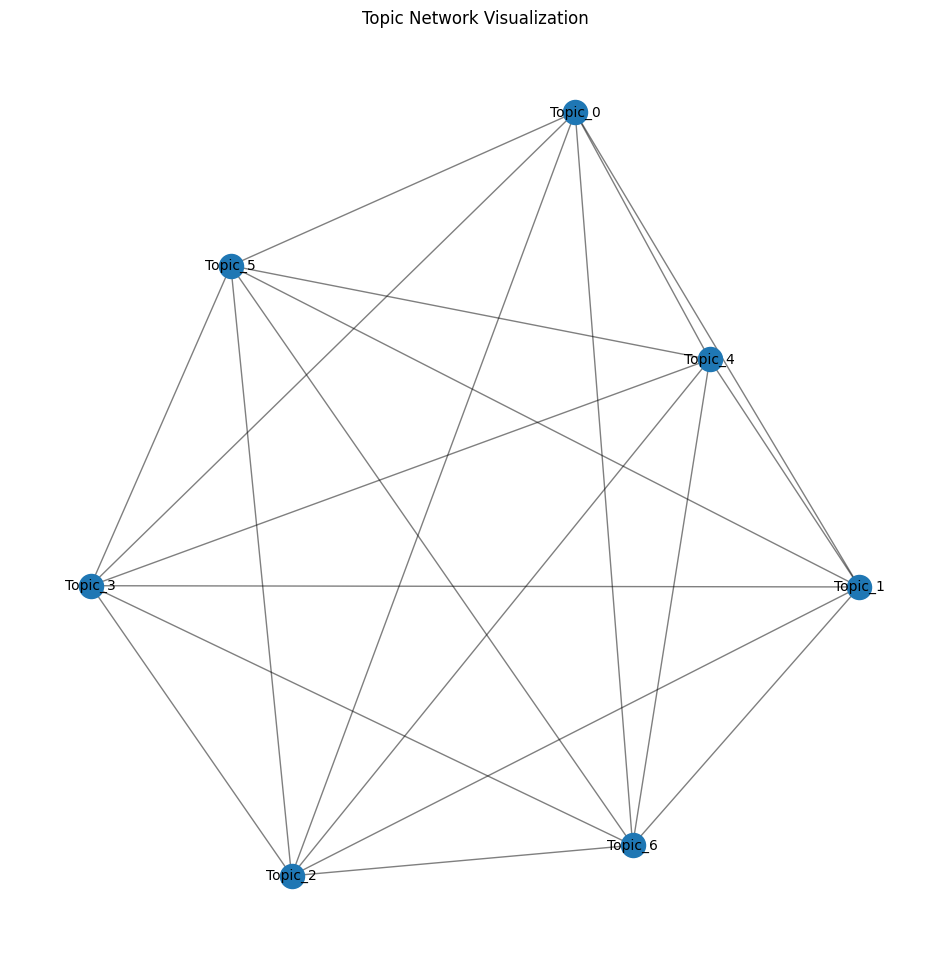

In [5]:
import os
import jieba
import re
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from community import community_louvain
import matplotlib.colors as mcolors

# 初始化 SparkSession
spark = SparkSession.builder \
    .appName("PySpark LDA Analysis with Gephi Export") \
    .getOrCreate()

# 自定義分詞函數並去除標點符號和非中文字符
def jieba_tokenize(text):
    text = re.sub(r"[^\u4e00-\u9fa5]", "", text)  # 只保留中文字符
    return list(jieba.cut(text))

# 讀取 CSV 文件
csv_path = "/home/rrrrryeedie/final_sorted_output.csv"
data = spark.read.csv(csv_path, header=True, inferSchema=True)

# 篩選需要的欄位，例如 'title' 和 'body'
data = data.select('title', 'body').dropna()

# 停用詞處理（自定義更多停用詞）
stopwords = set([
    '的', '了', '在', '是', '和', '也', '有', '我', '他', '她', '它', '就', '都', '很', '而', '但', '不', '這', '那',
    '與', '為', '個', '被', '與', '對', '和', '或', '能', '要', '更', '來', '看', '和', '而且', '是', '你', '我們', '她們',
    '會', '查核', '說', '表示', '於', '打', '影片', '網傳', '月', '年',
    '傳言', '年月日', '照片', '指出', '可能', '等', '可以', '吃', '因此', '所', '日', '製', '後', '目前', '報導',
    '到', '使用', '畫面', '事件', '發布', '人', '中心', '報告', '發生', '造成', '社群', '平台', '規定', '內容', '文章', '圖', '傳', '事實', '是否',
    '之', '以上', '流傳', '上', '及', '錯誤', '從', '若', '檢視', '更新版', '近期', '該', '一', '二','圖片', '網站' , '如果', '不會','可','讓','隨時','更新',
    '找到','出現', '原始', '背景','誤訊息', '沒', '沒有', '多', '影響','以','長','錯','再','用','中','不是','含有','隻','日期','報告將','因為', 
    '較', '部分', '相關', '並非', '歲', '反應', '已','宣稱','處理', '流傳訊息', '反','均','建議','者','時','資料','效果','快','顯示','不要','拍','元',
    '不同','未','至', '指稱','進行','由','稱','文字','比','搭配','無法','需要','增加','訊息','一網','通過', '含量', '擷圖', '字', '事故','喝',
    '軍','研究', '高','根據','才','應','編號','方式','提醒','功能','文件','一段','戴','篩','請','罰','管理','鈣','新','鍰','黃','三','申請',
    '結果','第條', '陳','處','此','蔡','英文','書', '版本','不能','狀況','相同','提供','活動','時間','搜','貼','無關','措施','跟','導致','新聞',
    '媒體','台灣','捲','蛇','標準','許量','一般','專家','趙', '傳言為', '提及', '透過', '台','控制','無','安全','民眾','帳號','軟體', '沖','來源',
    '檢索','曾', '直接','記者','員',  '內', '採訪', '去', '系統','工作','就是','擷','要求','地點','組織','通知','網頁', '其', '網路', '影像', '爭議點',
    '收到', '人員','任何','攝','分秒','秒','大量','植物', '片段','資訊','這是','為何','其他','以及','公布','結論','現場','蔔','向','人民','公民','看到','把',
    '另','真的','嗎','圖圖','發現','今年','利用','查證','當時','大利','做','一張','粉', '紓','公司','真實', '好', '特別', '問題','防部','並',
    '人數','標題','宣布','開始','一個','地','道','一名','向前','總','主要'
])

def process_text(text):
    if text is None:
        return []
    words = jieba.cut(re.sub(r"[^\u4e00-\u9fa5]", "", text))
    return [word for word in words if word not in stopwords]

# 定義分詞與去停用詞的 UDF
process_text_udf = udf(process_text, ArrayType(StringType()))
data = data.withColumn("filtered_words", process_text_udf(data["body"]))

# 設置 CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=5000, minDF=5)
vectorized_model = vectorizer.fit(data)
vectorized_data = vectorized_model.transform(data)

# 計算困惑度並選擇最佳主題數量
k_values = range(2, 21)  # 在此改變困惑度的選取範圍 要改參數的畫需要額外+1
perplexities = []
for k in k_values:
    lda = LDA(k=k, maxIter=10, featuresCol="features")
    model = lda.fit(vectorized_data)
    log_perplexity = model.logPerplexity(vectorized_data)
    perplexities.append(log_perplexity)

# 繪製困惑度曲線
plt.figure(figsize=(10, 6))
plt.plot(k_values, perplexities, marker="o")
plt.title("LDA Perplexity vs Number of Topics")
plt.xlabel("Number of Topics (k)")
plt.ylabel("Log Perplexity")
plt.show()

# 選擇困惑度最低的主題數量
optimal_k = k_values[np.argmin(perplexities)]
print(f"最佳主題數量: {optimal_k}")

# 使用最佳主題數量進行 LDA 分析
lda = LDA(k=optimal_k, maxIter=10, featuresCol="features")
lda_model = lda.fit(vectorized_data)

# 取得主題描述
topics = lda_model.describeTopics(10)
topics_pd = topics.toPandas()

# 提取關鍵詞對應的字詞
vocab_list = vectorized_model.vocabulary
topics_pd["terms"] = topics_pd["termIndices"].apply(lambda indices: [vocab_list[idx] for idx in indices])

# 新增打印關鍵詞和權重的程式碼
for i, row in topics_pd.iterrows():
    print(f"主題 {i}:")
    for term, weight in zip(row["terms"], row["termWeights"]):
        print(f"  {term}: {weight}")

# 將文檔主題分佈轉為 NumPy 矩陣
doc_topics = lda_model.transform(vectorized_data)
doc_topics_pd = doc_topics.select("title", "topicDistribution").toPandas()
doc_topics_pd["topicDistribution"] = doc_topics_pd["topicDistribution"].apply(
    lambda x: np.array(x, dtype=np.float64)
)

# 找到每篇文檔的主要主題
doc_topic_matrix = np.array(doc_topics_pd["topicDistribution"].tolist())
doc_topics_pd["dominant_topic"] = np.argmax(doc_topic_matrix, axis=1)

# 新增 dominant_score 欄位，提取每篇文檔的主要主題分數
doc_topics_pd["dominant_score"] = doc_topics_pd.apply(
    lambda row: row["topicDistribution"][row["dominant_topic"]], axis=1
)

# 按主題分組並提取前 5 篇文本
def extract_top_texts(doc_topics_pd):
    try:
        top_texts = doc_topics_pd.groupby("dominant_topic").apply(
            lambda df: df.sort_values(by="dominant_score", ascending=False).head(5) # 顯示最重要的
        )
        print("每個主題的 Top Texts:")
        for topic, group in top_texts.groupby(level=0):
            print(f"主題 {topic}:")
            for _, row in group.iterrows():
                print(f"  文本: {row['title']}, 分數: {row['dominant_score']}")
    except Exception as e:
        print(f"提取 Top Texts 時出現錯誤: {e}")

extract_top_texts(doc_topics_pd)

# 確保 topic_names 的長度與矩陣維度一致
topic_names = [f"Topic_{i}" for i in range(doc_topic_matrix.shape[1])]

# 修正後的網絡圖生成函數
def create_topic_network(theta_matrix, topic_names, weight_threshold=0.1):
    """
    創建主題網絡圖
    :param theta_matrix: 主題分佈矩陣 (文檔 x 主題)
    :param topic_names: 主題名稱列表
    :param weight_threshold: 權重閾值，僅顯示大於此閾值的邊
    :return: NetworkX Graph
    """
    # 檢查 theta_matrix 的維度和 topic_names 是否匹配
    if len(topic_names) != theta_matrix.shape[1]:
        raise ValueError("topic_names 的長度與主題矩陣的列數不匹配！")

    # 計算主題間的餘弦相似度
    cosine_sim = cosine_similarity(theta_matrix.T)  # 矩陣需轉置
    G = nx.Graph()

    # 創建圖結構
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i, j] > weight_threshold:  # 設定權重閾值
                print(f"配對: {topic_names[i]} - {topic_names[j]}, 權重: {cosine_sim[i, j]}")
                G.add_edge(topic_names[i], topic_names[j], weight=cosine_sim[i, j])

    # 使用 Louvain 方法進行社群檢測
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')
    return G

# 修正後的網絡視覺化函數
def visualize_network(G):
    """
    視覺化主題網絡圖，基於社群使用不同顏色
    :param G: NetworkX Graph
    """
    pos = nx.spring_layout(G, seed=42)  # 固定隨機種子，確保佈局一致
    plt.figure(figsize=(12, 12))

    communities = nx.get_node_attributes(G, 'community')
    unique_communities = set(communities.values())
    color_map = list(mcolors.TABLEAU_COLORS.values())

    for community in unique_communities:
        nodes = [node for node in G.nodes if communities[node] == community]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=300, 
                               node_color=color_map[community % len(color_map)])

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Topic Network Visualization")
    plt.axis('off')
    plt.show()

# 使用修正後的權重閾值生成網絡圖並視覺化
try:
    weight_threshold = 0.0001  # 需大於此權重閥值 才會顯示連線
    network = create_topic_network(doc_topic_matrix, topic_names, weight_threshold=weight_threshold)
    visualize_network(network)
except Exception as e:
    print(f"出現錯誤: {e}")
